# From `zipline` to `pyfolio`

## `pyfolio` Features

* State-of-the-art portfolio and risk analytics
* http://quantopian.github.io/pyfolio/
* Open source and free: Apache v2 license
* Can be used:
   - stand alone
   - with Zipline
   - on Quantopian
   - with PyThalesians

## Installation

* Use Anaconda to get a Python system with the full PyData ecosystem.
* `pip install pyfolio`

## Zipline + pyfolio

* Open-source backtester by Quantopian Inc.
* Powers Quantopian.com
* Various models for transaction costs and slippage.

In [12]:
from pathlib import Path
import warnings
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
from pyfolio.utils import extract_rets_pos_txn_from_zipline
from pyfolio.plotting import (plot_perf_stats,
                              show_perf_stats,
                              plot_rolling_beta,
                              plot_rolling_fama_french,
                              plot_rolling_returns,
                              plot_rolling_sharpe,
                              plot_rolling_volatility,
                              plot_drawdown_periods,
                              plot_drawdown_underwater)

from pyfolio.timeseries import perf_stats, extract_interesting_date_ranges
# from pyfolio.tears import create_returns_tear_sheet

In [14]:
%matplotlib inline
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [15]:
with pd.HDFStore('../01_trading_zipline/backtests.h5') as store:
    backtest = store['backtest']
backtest.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2015-01-02 to 2017-12-29
Data columns (total 39 columns):
algo_volatility            754 non-null float64
algorithm_period_return    755 non-null float64
alpha                      754 non-null float64
benchmark_period_return    755 non-null float64
benchmark_volatility       754 non-null float64
beta                       754 non-null float64
capital_used               755 non-null float64
ending_cash                755 non-null float64
ending_exposure            755 non-null float64
ending_value               755 non-null float64
excess_return              755 non-null float64
factor_data                755 non-null object
gross_leverage             755 non-null float64
long_exposure              755 non-null float64
long_value                 755 non-null float64
longs_count                755 non-null int64
max_drawdown               755 non-null float64
max_leverage               755 non-null float64
net_leverage   

## Converting data from zipline to pyfolio

In [16]:
returns, positions, transactions = extract_rets_pos_txn_from_zipline(backtest)

In [17]:
returns.head().append(returns.tail())

2015-01-02 00:00:00+00:00    0.000000
2015-01-05 00:00:00+00:00   -0.000001
2015-01-06 00:00:00+00:00   -0.001582
2015-01-07 00:00:00+00:00    0.000337
2015-01-08 00:00:00+00:00    0.000368
2017-12-22 00:00:00+00:00   -0.000249
2017-12-26 00:00:00+00:00   -0.003149
2017-12-27 00:00:00+00:00    0.003261
2017-12-28 00:00:00+00:00    0.001681
2017-12-29 00:00:00+00:00   -0.000368
Name: returns, dtype: float64

In [18]:
positions.columns = [c.symbol for c in positions.columns[:-1]] + ['cash']
positions.index = positions.index.normalize()
positions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 754 entries, 2015-01-05 to 2017-12-29
Columns: 529 entries, AAL to cash
dtypes: float64(529)
memory usage: 3.0 MB


In [19]:
transactions.symbol = transactions.symbol.apply(lambda x: x.symbol)

In [20]:
transactions.head().append(transactions.tail())

,amount,commission,dt,order_id,price,sid,symbol,txn_dollars
2015-01-05 21:00:00+00:00,11334,None,2015-01-05 21:00:00+00:00,5e563286a9014b6a91debaf50674ba68,13.970001,Equity(2076 [OCN]),OCN,-158335.989895
2015-01-05 21:00:00+00:00,4235,None,2015-01-05 21:00:00+00:00,271960b8933c42f8bf4afa484dc0b210,93.730000,Equity(2195 [PEP]),PEP,-396946.551716
2015-01-05 21:00:00+00:00,-2256,None,2015-01-05 21:00:00+00:00,f890da10d44f41db8caba6f7877aab51,92.049994,Equity(391 [BLUE]),BLUE,207664.787026
2015-01-06 21:00:00+00:00,15279,None,2015-01-06 21:00:00+00:00,5e563286a9014b6a91debaf50674ba68,13.480000,Equity(2076 [OCN]),OCN,-205960.925692
2015-01-06 21:00:00+00:00,-2127,None,2015-01-06 21:00:00+00:00,f890da10d44f41db8caba6f7877aab51,95.239997,Equity(391 [BLUE]),BLUE,202575.474323
2017-12-29 21:00:00+00:00,-1474,None,2017-12-29 21:00:00+00:00,aa2ae7e425ef4e91abeffbcf08f2191e,66.599997,Equity(2348 [QRVO]),QRVO,98168.395700
2017-12-29 21:00:00+00:00,-1476,None,2017-12-29 21:00:00+00:00,6a975a2df5b0404c92232f441ac129d0,42.569997,Equity(1743 [LYV]),LYV,62833.316075
2017-12-29 21:00:00+00:00,64,None,2017-12-29 21:00:00+00:00,4b39d9b302354a908e2e05d419683ba1,69.690000,Equity(946 [EMR]),EMR,-4460.160000
2017-12-29 21:00:00+00:00,-3183,None,2017-12-29 21:00:00+00:00,9f19d150f1b04490b39f8311fbb58679,21.170000,Equity(829 [DISCK]),DISCK,67384.108543
2017-12-29 21:00:00+00:00,-89,None,2017-12-29 21:00:00+00:00,5f1420c1ab52404cb5ca583784397ffb,96.020000,Equity(859 [DRI]),DRI,8545.780000


In [21]:
HDF_PATH = Path('..', '00_data', 'assets.h5')

### Sector Map

In [22]:
assets = positions.columns[:-1]
with pd.HDFStore(HDF_PATH) as store:
    df = store.get('us_equities/stocks')['sector'].dropna()
    df = df[~df.index.duplicated()]
sector_map = df.reindex(assets).fillna('Unknown').to_dict()

### Benchmark

In [23]:
with pd.HDFStore(HDF_PATH) as store:
    benchmark_rets = store['sp500/prices'].close.pct_change()
benchmark_rets.name = 'S&P500'
benchmark_rets = benchmark_rets.tz_localize('UTC').filter(returns.index)
benchmark_rets.tail()

date
2017-12-22 00:00:00+00:00   -0.000458
2017-12-26 00:00:00+00:00   -0.001058
2017-12-27 00:00:00+00:00    0.000791
2017-12-28 00:00:00+00:00    0.001834
2017-12-29 00:00:00+00:00   -0.005183
Name: S&P500, dtype: float64

In [24]:
perf_stats(returns=returns, factor_returns=benchmark_rets, positions=positions, transactions=transactions)

Annual return          0.017609
Cumulative returns     0.053688
Annual volatility      0.057912
Sharpe ratio           0.330315
Calmar ratio           0.174542
Stability              0.492038
Max drawdown          -0.100884
Omega ratio            1.062185
Sortino ratio          0.483141
Skew                   0.342805
Kurtosis               3.713327
Tail ratio             0.907589
Daily value at risk   -0.007220
Gross leverage         0.384621
Daily turnover         0.046732
Alpha                  0.005264
Beta                   0.146227
dtype: float64

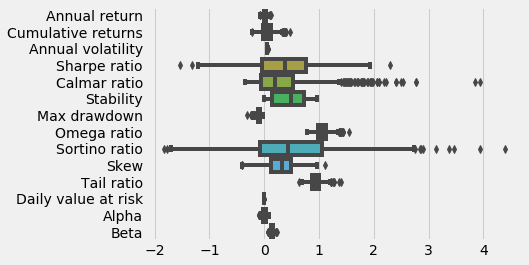

In [25]:
plot_perf_stats(returns=returns, factor_returns=benchmark_rets)

## Returns Analysis

In [26]:
oos_date = '2017-01-01'

In [27]:
show_perf_stats(returns=returns, 
                factor_returns=benchmark_rets, 
                positions=positions, 
                transactions=transactions, 
                live_start_date=oos_date)

In-sample months: 24
Out-of-sample months: 11


,All,In-sample,Out-of-sample
Annual return,1.8%,0.6%,4.2%
Cumulative returns,5.4%,1.1%,4.2%
Annual volatility,5.8%,6.3%,4.6%
Sharpe ratio,0.33,0.12,0.92
Calmar ratio,0.17,0.06,1.28
Stability,0.49,0.04,0.75
Max drawdown,-10.1%,-10.1%,-3.3%
Omega ratio,1.06,1.02,1.18
Sortino ratio,0.48,0.18,1.37
Skew,0.34,0.40,0.09


### Rolling Returns OOS

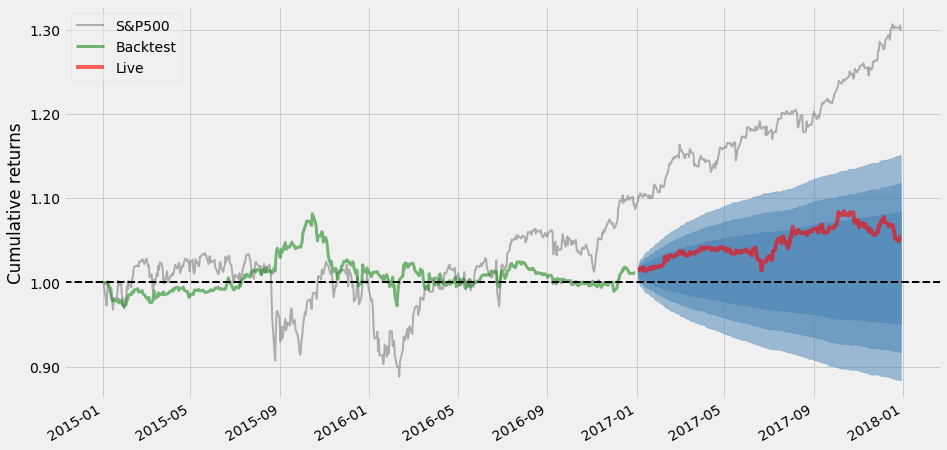

In [28]:
plot_rolling_returns(returns=returns, factor_returns=benchmark_rets, live_start_date=oos_date, cone_std=(1.0, 1.5, 2.0))
plt.gcf().set_size_inches(14, 8)

### Rolling Sharpe

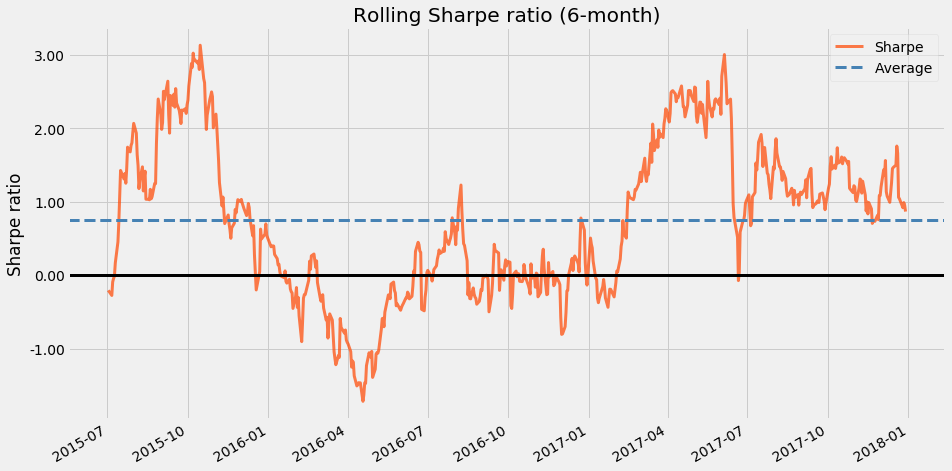

In [29]:
plot_rolling_sharpe(returns=returns)
plt.gcf().set_size_inches(14, 8);

### Rolling Beta

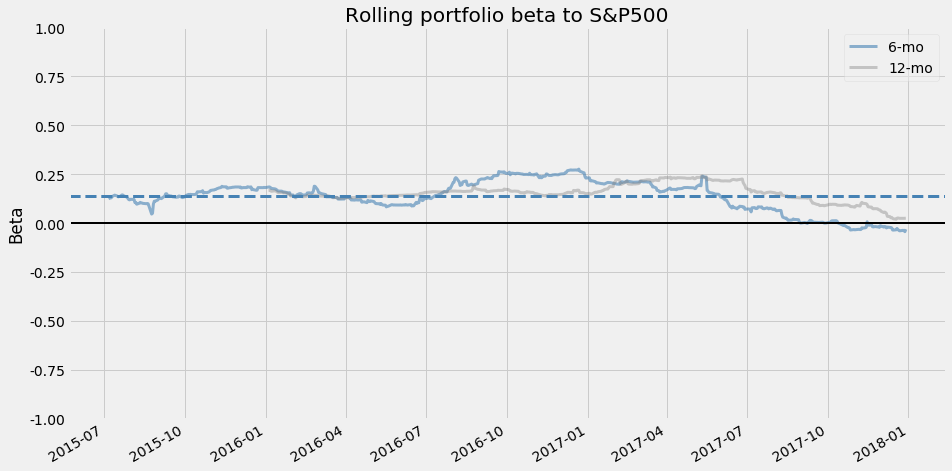

In [30]:
plot_rolling_beta(returns=returns, factor_returns=benchmark_rets)
plt.gcf().set_size_inches(14, 8);

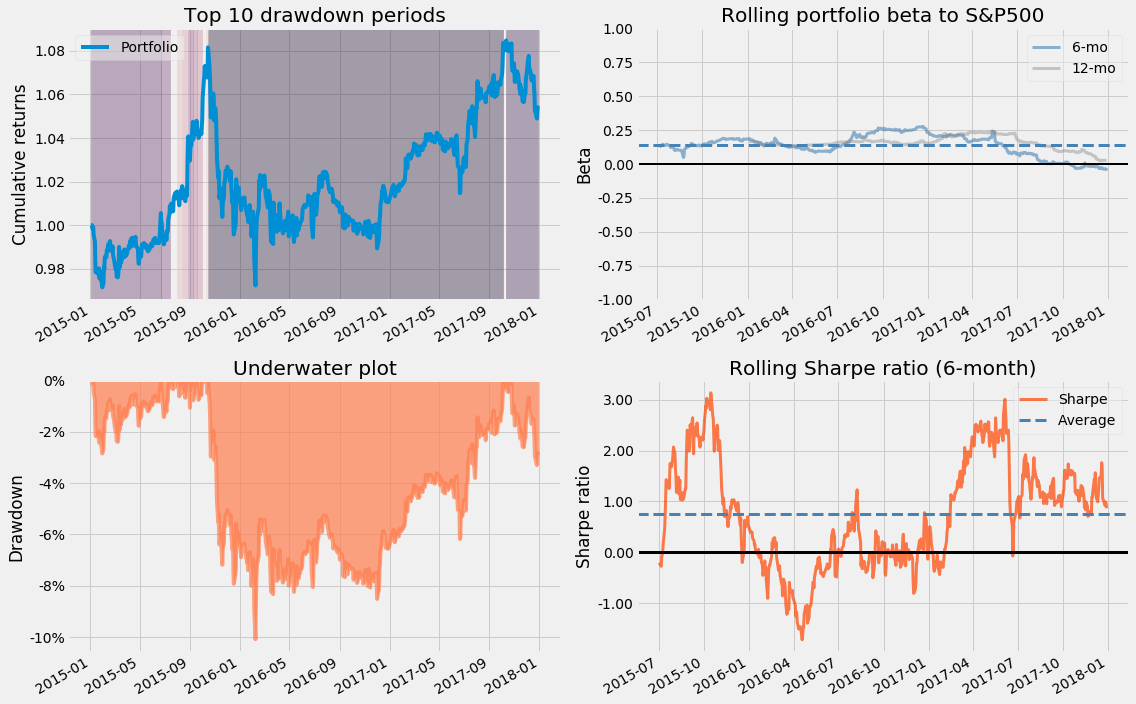

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
axes = ax.flatten()

plot_drawdown_periods(returns=returns, ax=axes[0])
plot_rolling_beta(returns=returns, factor_returns=benchmark_rets, ax=axes[1])
plot_drawdown_underwater(returns=returns, ax=axes[2])
plot_rolling_sharpe(returns=returns)
plt.tight_layout();

## Modeling Event Risk

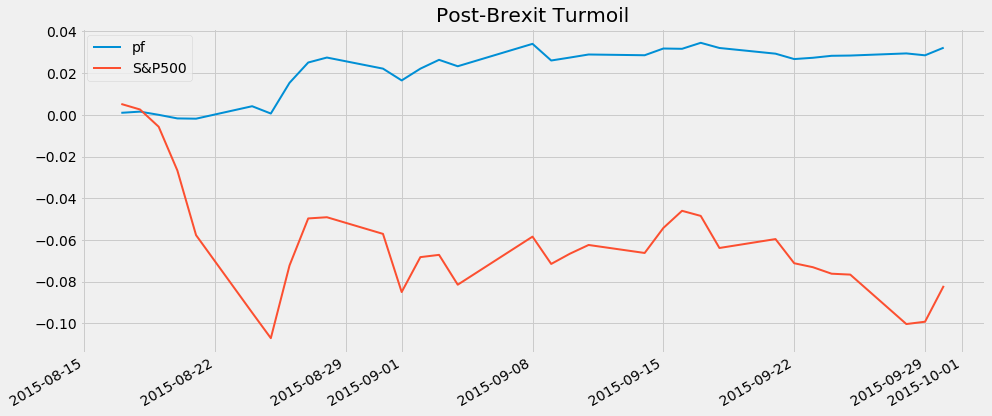

In [33]:
interesting_times = extract_interesting_date_ranges(returns=returns)
(interesting_times['Fall2015']
 .to_frame('pf').join(benchmark_rets)
 .add(1).cumprod().sub(1)
 .plot(lw=2, figsize=(14, 6), title='Post-Brexit Turmoil'))
plt.tight_layout()